<a href="https://colab.research.google.com/github/yarrib/fastai-projects-v2/blob/master/Fit_Simple_Fish_Model_ResNet34_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install fastai --upgrade
!pip install -Uqq fastbook




In [2]:
# imports and setup
import fastbook
fastbook.setup_book()

from fastai.vision.widgets import *
from fastai.vision.all import *
from fastbook import *
import os
!ls


Mounted at /content/gdrive
gdrive	sample_data


In [3]:
from google.colab import auth
auth.authenticate_user()

In [4]:
import os
os.getcwd()

'/content'

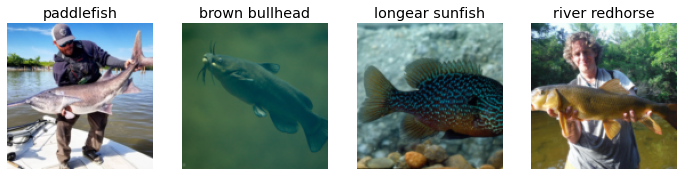

In [5]:
# get data by the path
path = Path('/content/gdrive/MyDrive/Colab Notebooks/fish')



fish = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))


dls = fish.dataloaders(path)

dls.valid.show_batch(max_n=4,nrows=1)

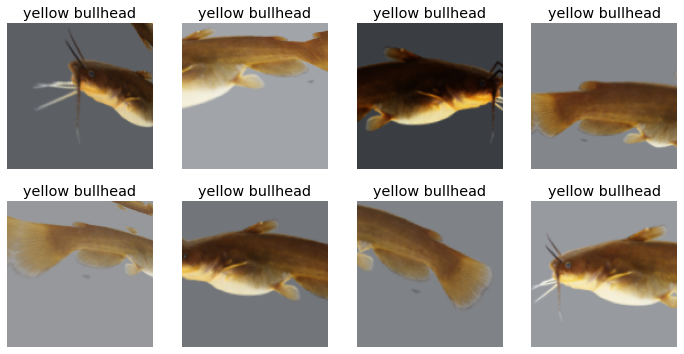

In [6]:
# example of random aumentation
f2 = fish.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = f2.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [7]:
fish = fish.new(item_tfms=RandomResizedCrop(224,min_scale=0.5),
                batch_tfms=aug_transforms())
dls = fish.dataloaders(path)

In [8]:
model_path = Path('/content/gdrive/MyDrive/Colab Notebooks/saved_models')
model_path

Path('/content/gdrive/MyDrive/Colab Notebooks/saved_models')

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,3.193991,1.807676,0.484468,16:29
1,1.957546,1.427486,0.397224,05:01
2,1.422455,1.346795,0.381362,05:03


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  

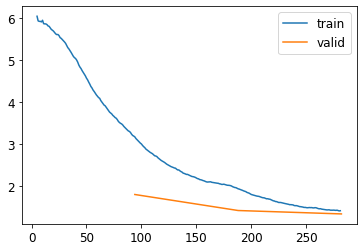

In [9]:
# initial training, saving the models after each epoch
# Do not forget to import the callback function
from fastai.callback.tracker import SaveModelCallback
# Train with the callback function set to save weights every epoch

learn = cnn_learner(dls, resnet34, metrics=error_rate)

#learn.fine_tune(epochs=10, freeze_epochs=2)

# fir for a few cycles on the head of the model
# by defacult we use discriminative learning rates in this method
learn.fit_one_cycle(3, 3e-3)
learn.recorder.plot_loss()

epoch,train_loss,valid_loss,error_rate,time
0,1.259306,1.310350,0.378057,05:10
1,1.223039,1.283546,0.372769,05:18
2,1.186111,1.223615,0.364177,05:07
3,1.076088,1.217415,0.365499,05:18
4,1.007849,1.164009,0.337740,05:33
5,0.967506,1.137269,0.331791,05:19
6,0.895079,1.104690,0.330469,05:19
7,0.850482,1.093901,0.324521,05:20
8,0.829764,1.087079,0.328486,05:15
9,0.814457,1.074614,0.318572,05:23


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  

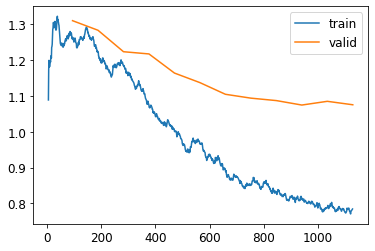

In [10]:
# unfreeze
learn.unfreeze()
# retrain the whole model with discriminative LR
learn.fit_one_cycle(12, lr_max=slice(1e-6, 1e-4))
learn.recorder.plot_loss()

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


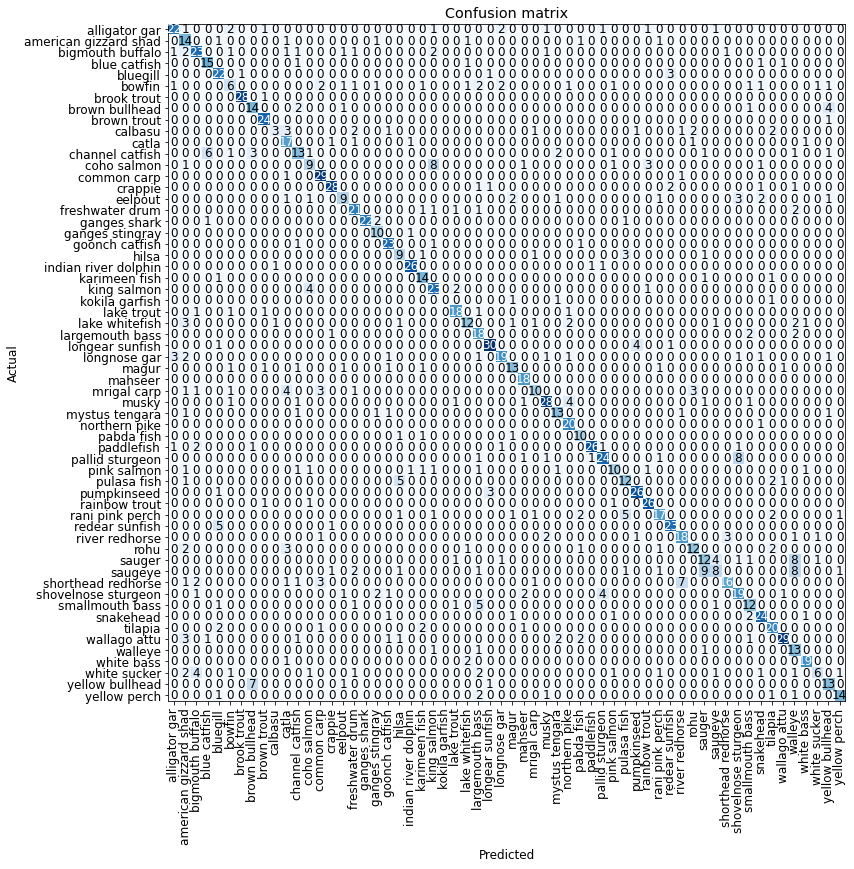

In [11]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(16,12))

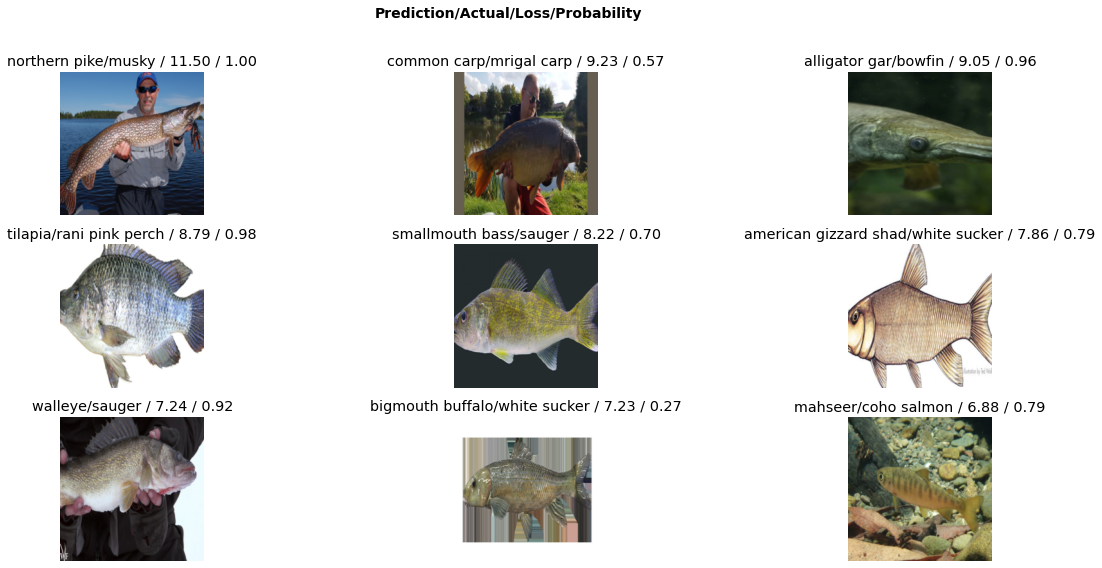

In [12]:
interp.plot_top_losses(12,nrows=3, figsize=(20,9))

In [ ]:
cleaner = ImageClassifierCleaner(learn)
cleaner

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


## use the cleaner methods to remove the junk images

In [14]:
# to delete
for idx in cleaner.delete():
  cleaner.fns[idx].unlink()

In [15]:
# to move
for idx,cat in cleaner.change():
  shutil.move(str(cleaner.fns[idx]),path/cat)

# Save the Model, then make preds

In [ ]:

model_path = Path('/content/gdrive/MyDrive/Colab Notebooks/saved_models')
import time

learn.export(fname=Path(model_path/f'export_resNet34_{time.time():.0f}.pkl'))

In [ ]:
# path = model_path
model_path.ls(file_exts='.pkl')

In [ ]:
latest_model = model_path.ls(file_exts='.pkl')[-1]
display(latest_model)
learn_inf = load_learner(latest_model)

In [ ]:
inf_path = Path('/content/gdrive/MyDrive/Colab Notebooks/real_life_fish_photos')
img_list = inf_path.ls(file_exts=['.jpeg', '.jpg', '.png'])
for i in img_list:
  print(i)

In [ ]:


  # now lets show the first few images in each of the first few directories
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

# create fig and axes
plt.figure()
fig,ax = plt.subplots(2,3,sharex=True, sharey=True, figsize=(15,10))

for i,m in enumerate(img_list):
    j=0
    if i > 2:
      j=1
      i-=3
    im = Image.open(m)
    ax[j,i].imshow(im.to_thumb(256,256),)
    ax[j,i].axis('off')


In [ ]:
for i in img_list:
  pred = learn_inf.predict(i)
  display(pred[0])